In [1]:
import warnings
import pandas as pd
import numpy as np
import re
import pyecharts as pe
import collections
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 图表可以显示中文



## 数据概览

In [2]:
df = pd.read_excel("豆瓣Top250.xlsx")
df.head()  # 查看前5行
# 获取数据列名
df.columns


Index(['排名', '评分', '电影名称', '导演', '编剧', '主演', '类型', '制片国家/地区', '语言', '上映日期',
       '片长', '又名', 'IMDb', '评分人数', '短评', '豆瓣链接'],
      dtype='object')

In [3]:
columns_remain = ['排名','电影名称', '导演', '编剧', '主演', '类型',
                  '制片国家/地区', '上映日期', '片长', '评分', '评分人数']
df = df[columns_remain]


In [4]:
# 查看数据的基本信息
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   排名       250 non-null    int64  
 1   电影名称     250 non-null    object 
 2   导演       250 non-null    object 
 3   编剧       249 non-null    object 
 4   主演       249 non-null    object 
 5   类型       250 non-null    object 
 6   制片国家/地区  250 non-null    object 
 7   上映日期     250 non-null    object 
 8   片长       250 non-null    object 
 9   评分       250 non-null    float64
 10  评分人数     250 non-null    int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 21.6+ KB


In [5]:
# 判断哪些列有空值
df.isnull().any()


排名         False
电影名称       False
导演         False
编剧          True
主演          True
类型         False
制片国家/地区    False
上映日期       False
片长         False
评分         False
评分人数       False
dtype: bool

主演、编剧这两列有空值，数据有249条，说明存在1个空值，详细看一下是哪一部电影；
评分列格式是浮点型，评分人数是整型，都没有空值，后面可以直接进行分析


In [6]:
# 筛选出主演为空值的数据
df[df['主演'].isnull()]


,排名,电影名称,导演,编剧,主演,类型,制片国家/地区,上映日期,片长,评分,评分人数
205,206,二十二,郭柯,NaN,NaN,纪录片,中国大陆,2017-08-14(中国大陆)/2015-10-05(釜山电影节)/2016-06-25(...,99分钟(公映版)/112分钟,8.7,265913


纪录片《二十二》的主演有空值，这个空值填充“缺失数据”

In [7]:
df.fillna('缺失数据', inplace=True)
df.isnull().any()


排名         False
电影名称       False
导演         False
编剧         False
主演         False
类型         False
制片国家/地区    False
上映日期       False
片长         False
评分         False
评分人数       False
dtype: bool

In [8]:
# 查看离散型变量的情况
df.describe()


,排名,评分,评分人数
count,250.000000,250.000000,2.500000e+02
mean,125.500000,8.917600,6.499965e+05
std,72.312977,0.267688,4.019263e+05
min,1.000000,8.300000,8.901500e+04
25%,63.250000,8.700000,3.791648e+05
50%,125.500000,8.900000,5.394915e+05
75%,187.750000,9.100000,7.852802e+05
max,250.000000,9.700000,2.533625e+06


评分情况，平均值8.918，最高评分9.7，最低分8.3分，后面进行可视化处理

## 数据清洗

豆瓣top250榜单详细电影名称

In [9]:
# 获取榜单里电影名称的中文名称
df['电影名称'] = df['电影名称'].apply(lambda x: x.split(' ')[0])
print(df['电影名称'].values.tolist()[0:10])


['肖申克的救赎', '霸王别姬', '阿甘正传', '泰坦尼克号', '这个杀手不太冷', '美丽人生', '千与千寻', '辛德勒的名单', '盗梦空间', '忠犬八公的故事']


很多单元格数据是以“/”来分割的，需要转化为列表形式，便于进行分析；
上映日期只要具体年份（年），片长只要具体时长（分钟）


In [10]:
string = '1998-04-03(中国大陆)/1997-11-01(东京电影节)/1997-12-19(美国)'
find = re.compile('\d{4}')
date = find.findall(string)
min(date)


'1997'

In [11]:
# 定义函数，将用"/" 分割的数据转化为列表
def conver_list(df, *columns):
    for column in columns:
        df[column] = df[column].str.split('/')
    return df


# 定义函数，用来获取最早上映日期
def get_date(x):
    find = re.compile('\d{4}')
    date = find.findall(x)
    earliest=min(date)
    return earliest


# '上映日期'和'片长'这两列，取具体的数字
df['上映日期'] = df['上映日期'].apply(get_date)
df['片长'] = df['片长'].map(lambda x: x.split('分钟')[0])

#  '导演', '主演', '类型', '制片国家/地区'，这几列下面的值转化为列表
df = conver_list(df, '导演', '主演', '类型', '制片国家/地区')

df.head()


,排名,电影名称,导演,编剧,主演,类型,制片国家/地区,上映日期,片长,评分,评分人数
0,1,肖申克的救赎,[弗兰克·德拉邦特],弗兰克·德拉邦特/斯蒂芬·金,"[蒂姆·罗宾斯, 摩根·弗里曼, 鲍勃·冈顿, 威廉姆·赛德勒, 克兰西·布朗, 吉尔·贝罗...","[剧情, 犯罪]",[美国],1994,142,9.7,2533625
1,2,霸王别姬,[陈凯歌],芦苇/李碧华,"[张国荣, 张丰毅, 巩俐, 葛优, 英达, 蒋雯丽, 吴大维, 吕齐, 雷汉, 尹治, 马...","[剧情, 爱情, 同性]","[中国大陆, 中国香港]",1993,171,9.6,1883284
2,3,阿甘正传,[罗伯特·泽米吉斯],艾瑞克·罗斯/温斯顿·格鲁姆,"[汤姆·汉克斯, 罗宾·怀特, 加里·西尼斯, 麦凯尔泰·威廉逊, 莎莉·菲尔德, 海利·乔...","[剧情, 爱情]",[美国],1994,142,9.5,1903425
3,4,泰坦尼克号,[詹姆斯·卡梅隆],詹姆斯·卡梅隆,"[莱昂纳多·迪卡普里奥, 凯特·温丝莱特, 比利·赞恩, 凯西·贝茨, 弗兰西丝·费舍, 格...","[剧情, 爱情, 灾难]","[美国, 墨西哥, 澳大利亚, 加拿大]",1997,194,9.4,1865115
4,5,这个杀手不太冷,[吕克·贝松],吕克·贝松,"[让·雷诺, 娜塔莉·波特曼, 加里·奥德曼, 丹尼·爱罗, 彼得·阿佩尔, 迈克尔·巴达鲁...","[剧情, 动作, 犯罪]","[法国, 美国]",1994,110,9.4,2062820


## 分析及可视化

### 电影上映日期分布情况

In [12]:
# 获取每一年上映的电影数量
df["上映日期"].value_counts()

2004    13
2010    13
1994    13
2015    11
2013    11
2003    10
2016    10
2008    10
2001     9
2009     9
2006     9
2014     9
1997     8
2011     8
2002     8
1993     7
1995     7
2018     6
1999     6
2012     5
2017     5
2000     5
1998     4
2007     4
1988     4
1991     4
2005     4
1987     3
1990     3
1992     2
1984     2
1957     2
1989     2
1986     2
2019     2
1996     2
1940     1
1968     1
1972     1
1982     1
1960     1
1936     1
1950     1
1979     1
1954     1
1952     1
1931     1
1975     1
1961     1
1966     1
1939     1
1965     1
1974     1
1953     1
Name: 上映日期, dtype: int64

In [13]:
df["上映日期"].value_counts().sort_index()


1931     1
1936     1
1939     1
1940     1
1950     1
1952     1
1953     1
1954     1
1957     2
1960     1
1961     1
1965     1
1966     1
1968     1
1972     1
1974     1
1975     1
1979     1
1982     1
1984     2
1986     2
1987     3
1988     4
1989     2
1990     3
1991     4
1992     2
1993     7
1994    13
1995     7
1996     2
1997     8
1998     4
1999     6
2000     5
2001     9
2002     8
2003    10
2004    13
2005     4
2006     9
2007     4
2008    10
2009     9
2010    13
2011     8
2012     5
2013    11
2014     9
2015    11
2016    10
2017     5
2018     6
2019     2
Name: 上映日期, dtype: int64

In [94]:
from pyecharts.charts import Bar
from pyecharts import options as opts
from snapshot_phantomjs import snapshot
from pyecharts.render import make_snapshot

x1 = list(df["上映日期"].value_counts().sort_index().index)
y1 = list(df["上映日期"].value_counts().sort_index().values)
y1 = [str(i) for i in y1]
year = Bar()
year.add_xaxis(x1)
year.add_yaxis("影片数量", y1)
year.set_global_opts(
    title_opts=opts.TitleOpts(title="豆瓣电影Top250上映日期分布情况"),
    xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=80)),
    # datazoom_opts=opts.DataZoomOpts(),

)

year.render("anlysis/电影上映日期分布情况.html")

year.render_notebook()


In [52]:
!snapshot "anlysis/电影上映日期分布情况.html" png


'name' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


Generating file ...
File saved in f:\04-程序员的个人修养\Python\豆瓣电影TOP250\output.png


豆瓣top250电影中，最早的一部是在1931年，名称是卓别林主演的《城市之光》，最新一部是在2019年上映的《寄生虫》，大部分电影上映年份分布在1987年到2019年之间，其中，1994,2004,2010年最多，都是13部


In [15]:
df[df['上映日期'] == '1931']


,排名,电影名称,导演,编剧,主演,类型,制片国家/地区,上映日期,片长,评分,评分人数
197,198,城市之光,[查理·卓别林],查理·卓别林/HarryClive/哈里·克罗克,"[查理·卓别林, 弗吉尼亚·切瑞尔, 佛罗伦斯·李, 亨利·伯格曼, 珍·哈露]","[剧情, 喜剧, 爱情]",[美国],1931,87,9.3,122119


In [16]:
df[df['上映日期'] == '2019']


,排名,电影名称,导演,编剧,主演,类型,制片国家/地区,上映日期,片长,评分,评分人数
147,148,寄生虫,[奉俊昊],奉俊昊/韩珍元,"[宋康昊, 李善均, 赵汝贞, 崔宇植, 朴素丹, 李姃垠, 张慧珍, 郑知晓, 朴明勋, ...","[剧情, 喜剧]",[韩国],2019,132,8.8,1204354
227,228,小丑,[托德·菲利普斯],托德·菲利普斯/斯科特·西尔弗/鲍勃·凯恩/比尔·芬格/杰瑞·罗宾逊,"[华金·菲尼克斯, 罗伯特·德尼罗, 马克·马龙, 莎姬·贝兹, 谢伊·惠格姆, 弗兰西丝·...","[剧情, 惊悚, 犯罪]","[美国, 加拿大]",2019,122,8.7,878629


### 电影制片国家地区分布情况

In [17]:
area_list = []
for i in df['制片国家/地区']:
    area_list.extend(i)
area_list[:10]


['美国', '中国大陆', '中国香港', '美国', '美国', '墨西哥', '澳大利亚', '加拿大', '法国', '美国']

制片国家/地区的总数量超过250,是因为部分电影是多个国家或地区合作的

In [18]:
len(area_list)


382

In [19]:
len(area_list)
area_count = collections.Counter(area_list)
print(area_count)


Counter({'美国': 138, '日本': 35, '英国': 35, '中国香港': 30, '中国大陆': 25, '法国': 19, '德国': 17, '韩国': 12, '意大利': 10, '加拿大': 9, '中国台湾': 8, '澳大利亚': 5, '印度': 4, '瑞士': 4, '西班牙': 4, '新西兰': 3, '瑞典': 2, '巴西': 2, '墨西哥': 1, '黎巴嫩': 1, '塞浦路斯': 1, '卡塔尔': 1, '波兰': 1, '伊朗': 1, '丹麦': 1, '荷兰': 1, '奥地利': 1, '南非': 1, '阿根廷': 1, '希腊': 1, '泰国': 1, '爱尔兰': 1, '阿联酋': 1, '摩纳哥': 1, '捷克': 1, '比利时': 1, '匈牙利': 1, '约旦': 1})


In [20]:
sort_area_count = sorted(area_count.items(), key=lambda x: x[1], reverse=True)
sort_area_count[:5]


[('美国', 138), ('日本', 35), ('英国', 35), ('中国香港', 30), ('中国大陆', 25)]

In [21]:
# 将排序后的字典转化为新的列表，作为横坐标轴、纵坐标轴
x2 = [x[0] for x in sort_area_count]
y2 = [x[1] for x in sort_area_count]


In [93]:
area = Bar()
area.add_xaxis(x2)
area.add_yaxis("影片数量", y2)
area.set_global_opts(
    title_opts=opts.TitleOpts(title="豆瓣电影Top250制片国家/地区分布情况"),
    xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=80)),
    # datazoom_opts=opts.DataZoomOpts(),
)

area.render("anlysis/电影制片国家地区分布情况.html")
area.render_notebook()


豆瓣top250电影，有138部电影是美国出品的，超过一半；中国（含大陆、香港、台湾）出品的有63部,接着是日本和英国

### 电影类型分布情况

In [23]:
type_list = []
for i in df['类型']:
    type_list.extend(i)

type_count = collections.Counter(type_list)
sort_type_count = sorted(type_count.items(), key=lambda x: x[1], reverse=True)

In [24]:
# 将排序后的字典转化为新的列表，作为横坐标轴、纵坐标轴
x3 = [x[0] for x in sort_type_count]
y3 = [x[1] for x in sort_type_count]

print('250部电影标签总数是：{}，平均每部电影标签数量是：{}。'.format(sum(y3), sum(y3)/250))


250部电影标签总数是：694，平均每部电影标签数量是：2.776。


In [25]:
list(zip(x3, y3))


[('剧情', 189),
 ('爱情', 57),
 ('喜剧', 56),
 ('冒险', 46),
 ('犯罪', 42),
 ('奇幻', 40),
 ('动画', 36),
 ('惊悚', 33),
 ('动作', 31),
 ('悬疑', 29),
 ('科幻', 23),
 ('家庭', 20),
 ('战争', 15),
 ('传记', 15),
 ('古装', 10),
 ('同性', 8),
 ('历史', 8),
 ('音乐', 8),
 ('歌舞', 6),
 ('儿童', 5),
 ('武侠', 4),
 ('西部', 3),
 ('纪录片', 3),
 ('灾难', 2),
 ('情色', 2),
 ('恐怖', 2),
 ('运动', 1)]

In [57]:
from pyecharts.charts import Pie, Grid, Bar, Line, Boxplot
from pyecharts.faker import Faker  # 数据包
from pyecharts.charts import Map, Geo
from pyecharts import options as opts
from pyecharts.globals import ThemeType
tag = (
    Pie(init_opts=opts.InitOpts(width="1000px", height="500px")) #创建一个饼图
    .add(
        "",  # 图名
        [[x, y] for x, y in zip(x3, y3) ] # 添加数据
    )
    # 设置标签
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}({d}%)"))
    .set_global_opts(
        # 图例列表的布局朝向。可选：'horizontal', 'vertical'
        title_opts=opts.TitleOpts(title="豆瓣电影Top250电影类型分布情况"),

        legend_opts=opts.LegendOpts(
            orient="vertical", pos_top="0%",pos_right="8%" # 图例设置
        ),
    )

)
tag.render('anlysis/电影类型分布情况.html')  # 保存到本地
tag.render_notebook()


可以看出，250部电影类型标签众多，有剧情、爱情、犯罪等等，恐怖片也有上榜，是《电锯惊魂》和《惊魂记》。跟制片国家/地区一样，一部电影可能有多个标签，所有类型标签加起来总共有694个，平均每部电影有2.776个标签，27.23%的标签是剧情，并不意味着有27.23%的电影是属于剧情片，实际上，剧情标签数量是189个，意味着250部电影里有189是属于剧情电影，占比达到75.6%，接近3/4。

In [27]:
df[['恐怖' in x for x in df['类型'].tolist()]]['电影名称']


155    电锯惊魂
171     惊魂记
Name: 电影名称, dtype: object

In [28]:

print("剧情片数量:", type_count['剧情'])
print("比例为:", type_count['剧情']/250)


剧情片数量: 189
比例为: 0.756


### 电影导演分析

In [29]:
director_list = []
for x in df['导演']:
    director_list.extend(x)
director_count = collections.Counter(director_list)
sort_director_count = sorted(
    director_count.items(), key=lambda x: x[1], reverse=True)


In [30]:
sort_director_count


[('宫崎骏', 8),
 ('史蒂文·斯皮尔伯格', 6),
 ('克里斯托弗·诺兰', 6),
 ('李安', 5),
 ('王家卫', 5),
 ('大卫·芬奇', 4),
 ('今敏', 4),
 ('是枝裕和', 4),
 ('詹姆斯·卡梅隆', 3),
 ('朱塞佩·托纳多雷', 3),
 ('刘镇伟', 3),
 ('弗朗西斯·福特·科波拉', 3),
 ('李·昂克里奇', 3),
 ('彼得·杰克逊', 3),
 ('彼特·道格特', 3),
 ('姜文', 3),
 ('莉莉·沃卓斯基', 3),
 ('拉娜·沃卓斯基', 3),
 ('昆汀·塔伦蒂诺', 3),
 ('理查德·林克莱特', 3),
 ('弗兰克·德拉邦特', 2),
 ('彼得·威尔', 2),
 ('刘伟强', 2),
 ('麦兆辉', 2),
 ('瑞奇·摩尔', 2),
 ('罗伯·莱纳', 2),
 ('克里斯·哥伦布', 2),
 ('查理·卓别林', 2),
 ('周星驰', 2),
 ('李力持', 2),
 ('奉俊昊', 2),
 ('中岛哲也', 2),
 ('蒂姆·波顿', 2),
 ('梅尔·吉布森', 2),
 ('森淳一', 2),
 ('杨德昌', 2),
 ('克里斯·桑德斯', 2),
 ('理查德·柯蒂斯', 2),
 ('黑泽明', 2),
 ('保罗·格林格拉斯', 2),
 ('吴宇森', 2),
 ('达米恩·查泽雷', 2),
 ('丹尼·博伊尔', 2),
 ('爱德华·兹威克', 2),
 ('安德鲁·尼科尔', 2),
 ('陈凯歌', 1),
 ('罗伯特·泽米吉斯', 1),
 ('吕克·贝松', 1),
 ('罗伯托·贝尼尼', 1),
 ('拉斯·霍尔斯道姆', 1),
 ('拉吉库马尔·希拉尼', 1),
 ('安德鲁·斯坦顿', 1),
 ('克里斯托夫·巴拉蒂', 1),
 ('拜伦·霍华德', 1),
 ('杰拉德·布什', 1),
 ('黄东赫', 1),
 ('加布里埃莱·穆奇诺', 1),
 ('比利·怀尔德', 1),
 ('奥利维埃·纳卡什', 1),
 ('埃里克·托莱达诺', 1),
 ('贝纳尔多·贝托鲁奇', 1),
 ('阿德里安·莫利纳', 1),
 ('张艺谋', 1),
 ('维克多·

In [72]:


x4 = [x[0] for x in sort_director_count][:20]
y4 = [x[1] for x in sort_director_count][:20]
director = (
    Bar(init_opts=opts.InitOpts(width="1200px", height="600px"))
    .add_xaxis(x4)
    .add_yaxis("影片数量", y4)
    .set_global_opts(
        title_opts=opts.TitleOpts(title="豆瓣电影Top250导演数量分布情况(前20位导演)"),
        xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=20)),
        # datazoom_opts=opts.DataZoomOpts(),
    )
) 


director.render("anlysis/电影导演分析.html")
director.render_notebook()


可以看到，宫崎骏第一，有8部电影入围豆瓣top250，史蒂文·斯皮尔伯格和克里斯托弗·诺兰都有6部入围豆瓣top250,中国导演李安、王家卫分别都有5部电影入围豆瓣top250，刘镇伟、姜文分别有3部电影入围豆瓣top250，
看一下克里斯托弗·诺兰有哪些电影入围豆瓣top250

In [32]:
df[['克里斯托弗·诺兰' in x for x in df['导演'].tolist()]]['电影名称']


8            盗梦空间
10           星际穿越
28       蝙蝠侠：黑暗骑士
77           致命魔术
114    蝙蝠侠：黑暗骑士崛起
172          记忆碎片
Name: 电影名称, dtype: object

星爷的喜剧之王和功夫入围豆瓣top250

In [33]:
df[['周星驰' in x for x in df['导演'].tolist()]]['电影名称']


88    喜剧之王
95      功夫
Name: 电影名称, dtype: object

In [98]:
df[['李安' in x for x in df['导演'].tolist()]]['电影名称']


40     少年派的奇幻漂流
61         饮食男女
102         断背山
153          喜宴
189         色，戒
Name: 电影名称, dtype: object

In [99]:
df[['宫崎骏' in x for x in df['导演'].tolist()]]['电影名称']


6         千与千寻
24          龙猫
39     哈尔的移动城堡
43        天空之城
107       幽灵公主
164        风之谷
196      魔女宅急便
231      崖上的波妞
Name: 电影名称, dtype: object

In [100]:
df[['史蒂文·斯皮尔伯格' in x for x in df['导演'].tolist()]]['电影名称']


7      辛德勒的名单
44       猫鼠游戏
70     拯救大兵瑞恩
128     幸福终点站
148      头号玩家
201      人工智能
Name: 电影名称, dtype: object

In [101]:
df[['王家卫' in x for x in df['导演'].tolist()]]['电影名称']

85     春光乍泄
108    重庆森林
157    花样年华
181    东邪西毒
233    阿飞正传
Name: 电影名称, dtype: object

### 电影主演分析



In [34]:
actor_list = []
for x in df['主演']:
    actor_list.extend(x)

actor_count = collections.Counter(actor_list)
sort_actor_count = sorted(
    actor_count.items(), key=lambda x: x[1], reverse=True)

sort_actor_count


[('张国荣', 8),
 ('梁朝伟', 8),
 ('马特·达蒙', 7),
 ('艾伦·瑞克曼', 7),
 ('雨果·维文', 7),
 ('张曼玉', 7),
 ('汤姆·汉克斯', 6),
 ('莱昂纳多·迪卡普里奥', 6),
 ('加里·奥德曼', 6),
 ('周星驰', 6),
 ('伊桑·霍克', 6),
 ('摩根·弗里曼', 5),
 ('拉尔夫·费因斯', 5),
 ('迈克尔·凯恩', 5),
 ('琼·艾伦', 5),
 ('约翰·拉岑贝格', 5),
 ('丹尼尔·雷德克里夫', 5),
 ('艾玛·沃森', 5),
 ('鲁伯特·格林特', 5),
 ('玛吉·史密斯', 5),
 ('汤姆·费尔顿', 5),
 ('邦妮·怀特', 5),
 ('刘嘉玲', 5),
 ('布拉德·皮特', 5),
 ('凯拉·奈特莉', 5),
 ('神木隆之介', 4),
 ('邦尼·亨特', 4),
 ('吴孟达', 4),
 ('阿尔·帕西诺', 4),
 ('朱丽·沃特斯', 4),
 ('维果·莫腾森', 4),
 ('奥兰多·布鲁姆', 4),
 ('肖恩·宾', 4),
 ('凯特·布兰切特', 4),
 ('安迪·瑟金斯', 4),
 ('大塚明夫', 4),
 ('凯瑞-安·莫斯', 4),
 ('山寺宏一', 4),
 ('林青霞', 4),
 ('树木希林', 4),
 ('邹兆龙', 4),
 ('巩俐', 3),
 ('葛优', 3),
 ('海利·乔·奥斯蒙', 3),
 ('伯纳德·希尔', 3),
 ('丹尼·爱罗', 3),
 ('连姆·尼森', 3),
 ('汤姆·哈迪', 3),
 ('基里安·墨菲', 3),
 ('玛丽昂·歌迪亚', 3),
 ('拉什·费加', 3),
 ('安妮·海瑟薇', 3),
 ('卡西·阿弗莱克', 3),
 ('乔什·斯图沃特', 3),
 ('阿米尔·汗', 3),
 ('杰斯·哈梅尔', 3),
 ('雅克·贝汉', 3),
 ('曾志伟', 3),
 ('陈冠希', 3),
 ('J·K·西蒙斯', 3),
 ('艾伦·图代克', 3),
 ('凯蒂·洛斯', 3),
 ('蓝洁瑛', 3),
 ('莫文蔚', 3),
 ('李健仁', 3),
 ('詹姆斯·肯恩', 

In [80]:

x6 = [x[0] for x in sort_actor_count][:20]
y6 = [x[1] for x in sort_actor_count][:20]
actor = (
    Bar(init_opts=opts.InitOpts(width="1000px", height="500px"))
    .add_xaxis(x6)
    .add_yaxis("影片数量", y6)
    .set_global_opts(
        title_opts=opts.TitleOpts(title="豆瓣电影Top250主演数量分布情况(前20位演员)"),
        xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=40)),
        # datazoom_opts=opts.DataZoomOpts(),
    )
)
grid=Grid()
grid.add(actor, grid_opts=opts.GridOpts(pos_bottom="20%"))
grid.render("anlysis/电影主演分析.html")
grid.render_notebook()


可以看到很多演员主演的电影质量是很高的，中国演员张国荣、梁朝伟主演的电影，分别有8部入围豆瓣top250，张曼玉有7部入围,周星驰有6部入围；张国荣、梁朝伟一起主演的电影有4部入围，分别是《春光乍泄》、《射雕英雄传之东成西就》、《东邪西毒》、《阿飞正传》。


In [82]:
list(df[['周星驰' in x for x in df['主演'].tolist()]]['电影名称'])


['大话西游之大圣娶亲', '大话西游之月光宝盒', '喜剧之王', '功夫', '唐伯虎点秋香', '九品芝麻官']

In [83]:
list(df[['张国荣' in x for x in df['主演'].tolist()]]['电影名称'])


['霸王别姬', '春光乍泄', '倩女幽魂', '射雕英雄传之东成西就', '英雄本色', '纵横四海', '东邪西毒', '阿飞正传']

In [37]:
df[['梁朝伟' in x for x in df['主演'].tolist()]]['电影名称']


16            无间道
85           春光乍泄
108          重庆森林
135    射雕英雄传之东成西就
157          花样年华
181          东邪西毒
189           色，戒
233          阿飞正传
Name: 电影名称, dtype: object

In [38]:
df[[('梁朝伟' in x and '张国荣' in x)for x in df['主演'].tolist()]]['电影名称']


85           春光乍泄
135    射雕英雄传之东成西就
181          东邪西毒
233          阿飞正传
Name: 电影名称, dtype: object

### 电影片长分析

In [85]:
time_list = sorted(df['片长'].astype('int').tolist())

length_anlysis = Boxplot()
_yaxis = length_anlysis.prepare_data([time_list])
length_anlysis .add_xaxis(['片长'])
length_anlysis .add_yaxis("",_yaxis)
length_anlysis.set_global_opts(
    title_opts=opts.TitleOpts(title="豆瓣Top250电影片长分析"))

length_anlysis.render("anlysis/电影片长分析.html")
length_anlysis.render_notebook()


250部电影片长分布挺集中的，其中，最长的电影有238分钟，最短的只有45分钟，平均片长是118分钟，通过查看数据可以发现，片长最长的是《乱世佳人》，片长最短的是《萤火之森》。



In [40]:
print(df[df['片长'] == '238']['电影名称'])
print(df[df['片长'] == '45']['电影名称'])


32    乱世佳人
Name: 电影名称, dtype: object
126    萤火之森
Name: 电影名称, dtype: object


### 电影排名&评分&评分人数情况分析


用matplotlib绘图，将电影排名、评分、评分人数，3个维度的数据绘制在一张图上

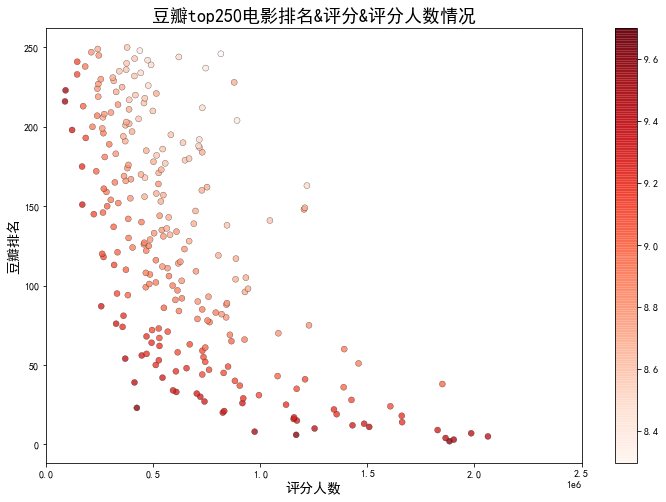

In [95]:
x5 = df['评分人数'].tolist()
y5 = df['评分'].tolist()
z = df['排名'].tolist()

plt.figure(figsize=(12, 8))
plt.scatter(x=x5,
            y=z,
            cmap='Reds',
            marker='o',
            c=y5,   # 数字越大，颜色越深，评分越高
            alpha=0.8,
            linewidths=0.3,
            edgecolors='Black')

plt.title('豆瓣top250电影排名&评分&评分人数情况', fontsize=18)
plt.xlabel('评分人数', fontsize=14)
plt.ylabel('豆瓣排名', fontsize=14)
plt.xlim(0, 2500000)
plt.colorbar()
plt.savefig("anlysis/豆瓣top250电影排名&评分&评分人数情况.svg")


豆瓣电影Top250中的所有电影评分都在8分以上，最低评分8.3是国产电影《驴得水》，最高评分9.7《肖申克的救赎》,豆瓣电影TOP250中TOP50的平均得分高达 9.266。评分人数大部分在100万以内,只有35部高于100万人次评价,其中27部都是排名TOP50以内的电影。可以大致看出，非常经典的电影，豆瓣排名、评分人数、评分都很高

In [42]:
# 最高评分
df[df['评分'] == df['评分'].max()]


,排名,电影名称,导演,编剧,主演,类型,制片国家/地区,上映日期,片长,评分,评分人数
0,1,肖申克的救赎,[弗兰克·德拉邦特],弗兰克·德拉邦特/斯蒂芬·金,"[蒂姆·罗宾斯, 摩根·弗里曼, 鲍勃·冈顿, 威廉姆·赛德勒, 克兰西·布朗, 吉尔·贝罗...","[剧情, 犯罪]",[美国],1994,142,9.7,2533625


In [43]:
# 最低评分
df[df['评分'] == df['评分'].min()]


,排名,电影名称,导演,编剧,主演,类型,制片国家/地区,上映日期,片长,评分,评分人数
245,246,驴得水,"[周申, 刘露]",周申/刘露,"[任素汐, 大力, 刘帅良, 裴魁山, 阿如那, 韩彦博, 卜冠今, 王堃, 高阳, 苏千越...","[剧情, 喜剧]",[中国大陆],2016,111,8.3,816355


In [44]:

print("豆瓣电影TOP250中TOP50的平均得分高达", df.iloc[0:50, ]["评分"].mean())


豆瓣电影TOP250中TOP50的平均得分高达 9.266000000000005


In [45]:
num_m=len(df[df["评分人数"] > 1000000])
print(f"至少100万人评分的电影有{num_m}部",)
df_=df[df["评分人数"] > 1000000]
num_50=len(df_[df_['排名'] < 50])
print(f"其中位于TOP50的有{num_50}部",)


至少100万人评分的电影有35部
其中位于TOP50的有27部


In [97]:
df1 = df.sort_values(by="评分人数", ascending=False).iloc[0:20, ]
comments=(
    Bar()
    .add_xaxis(df1["电影名称"].to_list())
    .add_yaxis("评分人数", df1["评分人数"].to_list())
    .reversal_axis()
    .set_series_opts(label_opts=opts.LabelOpts(position="right"))
    .set_global_opts(title_opts=opts.TitleOpts(title="豆瓣电影Top250中最多评分人数的电影（前20部）"))
    )
comments.render("anlysis/电影评分人数Top20.html")
comments.render_notebook()


在电影评分人数TOP20中,可以看到肖申克的救赎不愧为榜1,253万评分人次,独领风骚,其次是这个杀手不太冷206万评分,千与千寻198万评分,阿甘正传190万评分人次,霸王别姬作为中国最好电影,评分人次也有188万(很遗憾的说,我还没看过霸王别姬,年龄太小啦,看也看不懂)

In [128]:
df1=df.sort_values(by="评分人数", ascending=False)


def find_China(area_list):
    find = re.compile('中国+')
    flag = False
    for i in area_list:
        m = find.search(i)
        if m:
            return True
    return False


df2=df1[[find_China(x) for x in df1["制片国家/地区"].tolist()]][["排名","电影名称","导演","编剧","评分","评分人数"]].iloc[0:30]
print(df2.to_markdown(index=False))


|   排名 | 电影名称             | 导演                  | 编剧                                                 |   评分 |   评分人数 |
|-------:|:---------------------|:----------------------|:-----------------------------------------------------|-------:|-----------:|
|      2 | 霸王别姬             | ['陈凯歌']            | 芦苇/李碧华                                          |    9.6 |    1883284 |
|     38 | 我不是药神           | ['文牧野']            | 韩家女/钟伟/文牧野                                   |    9   |    1850246 |
|     51 | 让子弹飞             | ['姜文']              | 朱苏进/述平/姜文/郭俊立/危笑/李不空/马识途           |    8.9 |    1459151 |
|     60 | 绿皮书               | ['彼得·法雷里']       | 尼克·瓦莱隆加/布莱恩·库瑞/彼得·法雷里                |    8.9 |    1392106 |
|     19 | 大话西游之大圣娶亲   | ['刘镇伟']            | 刘镇伟                                               |    9.2 |    1356821 |
|     41 | 少年派的奇幻漂流     | ['李安']              | 扬·马特尔/大卫·麦基                                  |    9.1 |    1209381 |
|     17 | 无间道               | ['刘伟强', '麦兆辉']

In [113]:
df1

,排名,电影名称,导演,编剧,主演,类型,制片国家/地区,上映日期,片长,评分,评分人数
0,1,肖申克的救赎,[弗兰克·德拉邦特],弗兰克·德拉邦特/斯蒂芬·金,"[蒂姆·罗宾斯, 摩根·弗里曼, 鲍勃·冈顿, 威廉姆·赛德勒, 克兰西·布朗, 吉尔·贝罗...","[剧情, 犯罪]",[美国],1994,142,9.7,2533625
4,5,这个杀手不太冷,[吕克·贝松],吕克·贝松,"[让·雷诺, 娜塔莉·波特曼, 加里·奥德曼, 丹尼·爱罗, 彼得·阿佩尔, 迈克尔·巴达鲁...","[剧情, 动作, 犯罪]","[法国, 美国]",1994,110,9.4,2062820
6,7,千与千寻,[宫崎骏],宫崎骏,"[柊瑠美, 入野自由, 夏木真理, 菅原文太, 中村彰男, 玉井夕海, 神木隆之介, 内藤刚...","[剧情, 动画, 奇幻]",[日本],2001,125,9.4,1984634
2,3,阿甘正传,[罗伯特·泽米吉斯],艾瑞克·罗斯/温斯顿·格鲁姆,"[汤姆·汉克斯, 罗宾·怀特, 加里·西尼斯, 麦凯尔泰·威廉逊, 莎莉·菲尔德, 海利·乔...","[剧情, 爱情]",[美国],1994,142,9.5,1903425
1,2,霸王别姬,[陈凯歌],芦苇/李碧华,"[张国荣, 张丰毅, 巩俐, 葛优, 英达, 蒋雯丽, 吴大维, 吕齐, 雷汉, 尹治, 马...","[剧情, 爱情, 同性]","[中国大陆, 中国香港]",1993,171,9.6,1883284
...,...,...,...,...,...,...,...,...,...,...,...
240,241,我爱你,[秋昌旼],姜草/秋昌旼,"[宋在浩, 李顺载, 尹秀晶, 金秀美, 宋智孝, 吴达洙]","[剧情, 爱情]",[韩国],2011,118,9.1,146094
232,233,海洋,"[雅克·贝汉, 雅克·克鲁奥德]",克里斯托夫·谢松/雅克·克鲁奥德/洛朗·德巴/斯特凡纳·迪朗/洛朗·戈德/雅克·贝汉/弗朗索...,"[皮尔斯·布鲁斯南, 小佩德罗·阿门达里斯, 雅克·贝汉, 宫泽理惠, 马蒂亚斯·勃兰特, ...",[纪录片],"[法国, 瑞士, 西班牙, 美国, 阿联酋, 摩纳哥]",2009,104,9.1,145526
197,198,城市之光,[查理·卓别林],查理·卓别林/HarryClive/哈里·克罗克,"[查理·卓别林, 弗吉尼亚·切瑞尔, 佛罗伦斯·李, 亨利·伯格曼, 珍·哈露]","[剧情, 喜剧, 爱情]",[美国],1931,87,9.3,122119
222,223,背靠背，脸对脸,"[黄建新, 杨亚洲]",黄建新/孙毅安/刘醒龙,"[牛振华, 雷恪生, 李强, 句号, 王劲松, 戈治均, 佘南南, 张嘉益, 刘国祥, 徐学...",[剧情],"[中国大陆, 中国香港]",1994,148,9.5,91645
